In [1]:
import cv2
import numpy as np
from sklearn.cluster import DBSCAN, KMeans
import sys
from timeit import default_timer as time
import pandas as pd

sys.path.insert(0, '../')
from utils.color_embedding import TFColorEmbedding
from utils.array_utils import get_median_intensive_value
from utils.visualization import draw_colors_horizontal_circles, add_color_bar_to_image
from utils.topological_colors_extraction import colors_grouping, get_class_index_from_groups

sys.path.insert(0, '../third_party/umato/')
import umato

from matplotlib import pyplot as plt
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
%matplotlib inline

figure_size = (10, 8)

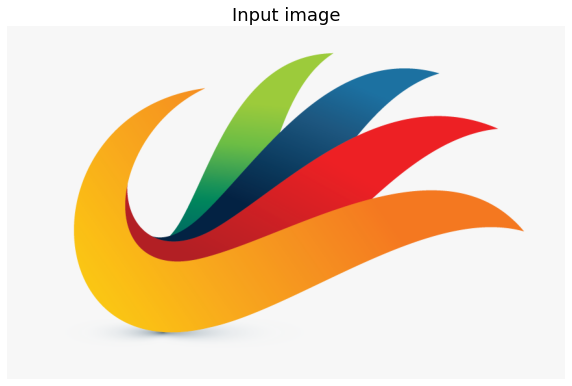

Resize time: 0.00042 sec
Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
'model_variables' collection should be of type 'byte_list', but instead is of type 'node_list'.
INFO:tensorflow:Restoring parameters from ../third_party/palette_embedding/python/../model/variables/variables


In [2]:
# Loading input image

image_path = '../examples/logo_3.png'
img = cv2.imread(image_path, cv2.IMREAD_COLOR)

if img is None:
    print('Can\'t load image: {}'.format(image_path))
    
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Input image', fontsize=18)
plt.imshow(img)
plt.show()

# Resize image
start_time = time()
resized = img.copy()
if max(resized.shape) > 50:
    resized_k = 50 / max(resized.shape)
    resized = cv2.resize(
        resized,
        None,
        fx=resized_k,
        fy=resized_k,
        interpolation=cv2.INTER_CUBIC
    )
finish_time = time()
resizing_time = finish_time - start_time
print('Resize time: {:.5f} sec'.format(resizing_time))
    
color_embdding_model = TFColorEmbedding()

Colors embeddings prediction time: 0.51 sec
UMATO dimensionality reduction time: 5.19 sec


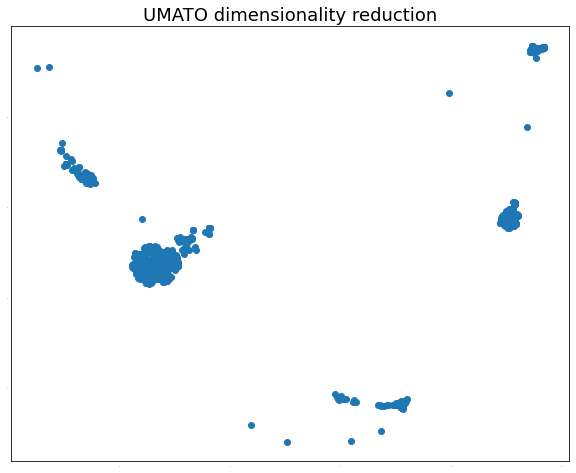

In [4]:
# Colors embeddings prediction
start_time = time()
pixels = np.array([color_embdding_model(cl) for cl in resized.reshape((-1, 3))])
finish_time = time()
emdebbins_time = finish_time - start_time
print('Colors embeddings prediction time: {:.2f} sec'.format(emdebbins_time))

# Fake run to initial compilation numba functions.
# Next runs are more fastly due to numba acceleration
_  = umato.UMATO().fit_transform(np.random.rand(1000, 10))

# UMATO dimensionality reduction
start_time = time()
comp_pixels = umato.UMATO(
    n_neighbors=250,
    global_n_epochs=50,
    local_n_epochs=50,
    hub_num=300,
    verbose=False,
    init='spectral',
    random_state=42
).fit_transform(pixels)
finish_time = time()
umato_time = finish_time - start_time
print('UMATO dimensionality reduction time: {:.2f} sec'.format(umato_time))

plt.figure(figsize=figure_size)
plt.title('UMATO dimensionality reduction', fontsize=18)
plt.scatter(comp_pixels[:, 0], comp_pixels[:, 1])
plt.tick_params(axis='both', labelsize=0, length = 0)
plt.show()

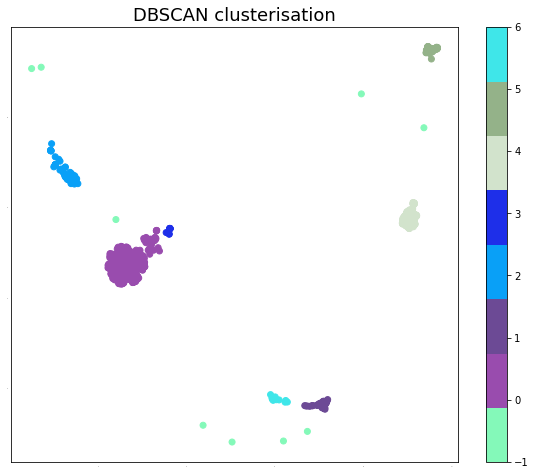

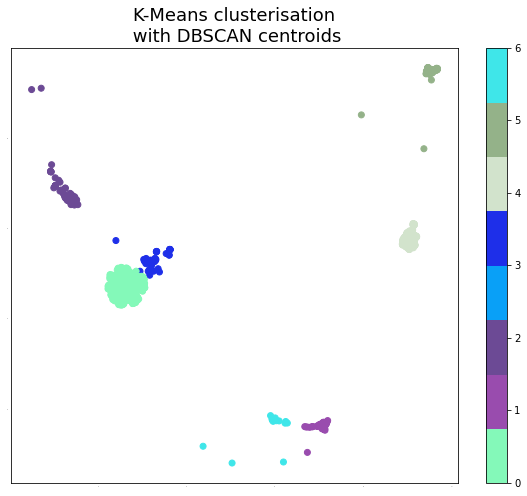

Clusterisation time: 0.36 sec


In [5]:
# First step of clusterisation
start_time = time()
clustering = DBSCAN(
    eps=0.2,
    min_samples=4,
    n_jobs=12
).fit(comp_pixels)

clusters_centroids = np.array([
    comp_pixels[clustering.labels_ == i].mean(axis=0)
    for i in set(clustering.labels_)
    if i != -1
])
finish_time = time()
dbscan_time = finish_time - start_time

# For visuazliation
colors = np.random.randint(0, 255, size=(len(set(clustering.labels_)), 3), dtype=np.uint8)
full_cmp = ListedColormap(colors / 255.0)

plt.figure(figsize=figure_size)
plt.title('DBSCAN clusterisation', fontsize=18)
plt.scatter(
    comp_pixels[:, 0], comp_pixels[:, 1], 
    c=clustering.labels_,
    cmap=full_cmp
)
plt.colorbar()
plt.tick_params(axis='both', labelsize=0, length = 0)

# Second step of clusterisation
start_time = time()
k_means_clustering = KMeans(
    n_clusters=len([cl for cl in set(clustering.labels_) if cl != -1]),
    n_init=1,
    n_jobs=4,
    init=clusters_centroids,
    random_state=42
).fit(comp_pixels)
finish_time = time()
kmeans_time = finish_time - start_time

plt.figure(figsize=figure_size)
plt.title('K-Means clusterisation\n with DBSCAN centroids', fontsize=18)
plt.scatter(
    comp_pixels[:, 0], comp_pixels[:, 1], 
    c=k_means_clustering.labels_,
    cmap=np.roll(full_cmp, 2).tolist()
)
plt.colorbar()
plt.tick_params(axis='both', labelsize=0, length = 0)

plt.show()

clustering = k_means_clustering
print('Clusterisation time: {:.2f} sec'.format(dbscan_time + kmeans_time))

Centroids estimation time: 0.00118 sec


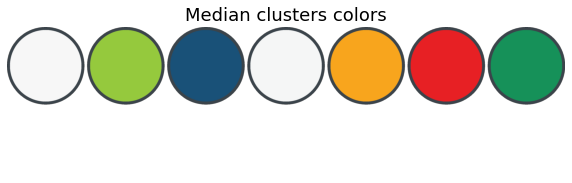

In [6]:
start_time = time()
cluster_values = [
    resized.reshape((-1, 3))[clustering.labels_ == i]
    for i in set(clustering.labels_)
]

cluster_values = [
    get_median_intensive_value(np.array(cluster_values[i]))
    for i in range(len(cluster_values))
]
finish_time = time()
centroids_estimation_time = finish_time - start_time
print('Centroids estimation time: {:.5f} sec'.format(centroids_estimation_time))

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Median clusters colors', fontsize=18)
plt.imshow(draw_colors_horizontal_circles(cluster_values))
plt.show()

Colors grouping time: 0.00133 sec


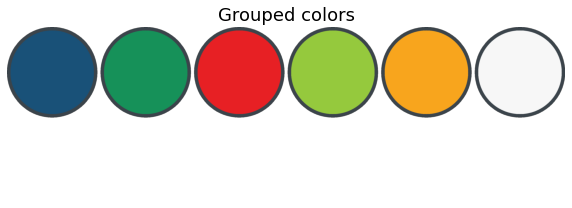

In [7]:
start_time = time()
cluster_values_with_sorted_indexes = list(
    zip(cluster_values, range(len(cluster_values))))
cluster_values_with_sorted_indexes.sort(key=lambda x: x[0].mean(),
                                        reverse=False)

grouping_indexes = colors_grouping(
    [cl[0] for cl in cluster_values_with_sorted_indexes],
    65
)

grouping_indexes = [
    [cluster_values_with_sorted_indexes[v][1] for v in g]
    for g in grouping_indexes
]

grouped_colors = [
    cluster_values[get_class_index_from_groups(grouping_indexes, g[0])]
    for g in grouping_indexes
]
finish_time = time()
colors_grouping_time = finish_time - start_time
print('Colors grouping time: {:.5f} sec'.format(colors_grouping_time))

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Grouped colors', fontsize=18)
plt.imshow(draw_colors_horizontal_circles(grouped_colors))
plt.show()

Quantization time: 0.00229 sec


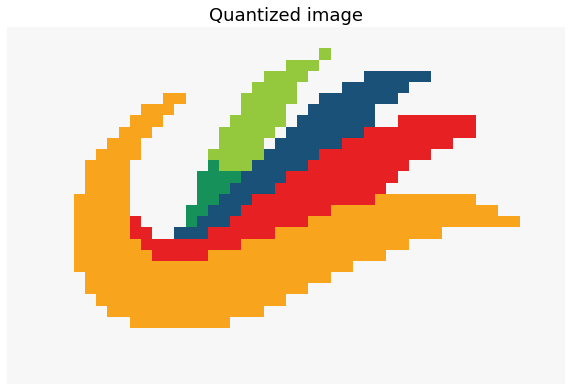

In [8]:
# We know that it is possible to calculate areas from the size of the clusters. 
# We wanted to visually demonstrate the quantized image.
start_time = time()
clusters_set = list(set(clustering.labels_))

quantized_resized_img = np.array([
    cluster_values[
        get_class_index_from_groups(
            grouping_indexes,
            clusters_set.index(clustering.labels_[i])
        )
    ]
    for i, p in enumerate(resized.reshape((-1, 3)))
]).reshape(resized.shape)
finish_time = time()
quantization_time = finish_time - start_time
print('Quantization time: {:.5f} sec'.format(quantization_time))

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Quantized image', fontsize=18)
plt.imshow(quantized_resized_img)
plt.show()

Area estimation time: 0.00181 sec


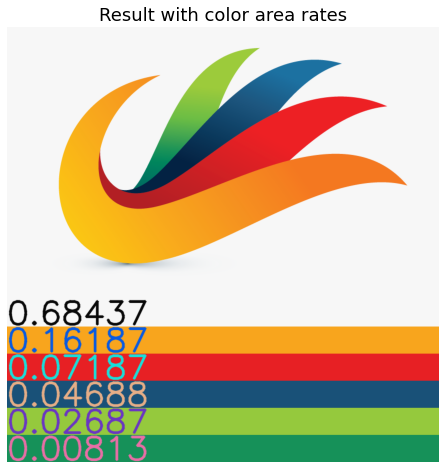

In [9]:
start_time = time()
total_colors, cover_rates = np.unique(
    quantized_resized_img.reshape((-1, 3)),
    axis=0,
    return_counts=True
)

cover_rates = np.array([
    count / np.sum(cover_rates)
    for count in cover_rates
])

colors_with_rates = [
    (total_colors[i], cover_rates[i]) for i in range(len(cover_rates))
]
colors_with_rates = sorted(
    colors_with_rates,
    key=lambda x: x[1],
    reverse=True
)

total_colors = [tup[0] for tup in colors_with_rates]
cover_rates = [tup[1] for tup in colors_with_rates]
finish_time = time()
area_estimation_time = finish_time - start_time
print('Area estimation time: {:.5f} sec'.format(area_estimation_time))

plt.figure(figsize=figure_size)
plt.axis('off')
plt.title('Result with color area rates', fontsize=18)
plt.imshow(add_color_bar_to_image(img, total_colors, cover_rates))
plt.show()

In [10]:
total_time = resizing_time + emdebbins_time + umato_time + dbscan_time + kmeans_time
total_time += centroids_estimation_time + colors_grouping_time + quantization_time
total_time += area_estimation_time

df = pd.DataFrame(
    {
        'Algorithm step': [
            'Resize',
            'Embeddings prediction',
            'UMATO dimensionality reduction', 
            'Clusterisation',
            'Centroids estimation',
            'Colors grouping',
            'Quantization',
            'Area estimation',
            'Total'
        ],
        'Time in sec': [
            resizing_time, emdebbins_time, umato_time,
            dbscan_time + kmeans_time,
            centroids_estimation_time, colors_grouping_time,
            quantization_time, area_estimation_time,
            total_time
        ]
    }
)

df

,Algorithm step,Time in sec
0,Resize,0.000416
1,Embeddings prediction,0.505385
2,UMATO dimensionality reduction,5.191670
3,Clusterisation,0.364865
4,Centroids estimation,0.001181
5,Colors grouping,0.001331
6,Quantization,0.002293
7,Area estimation,0.001807
8,Total,6.068948
